# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))
sys.path.append(str(USER_ROOT / 'ed-predictor' / 'functions'))


model_file_path = PROJECT_ROOT /'data' / 'ed-predictor' / 'trained-models'
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
uclh = False

In [4]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]




## Load data

In [6]:
import pandas as pd
from load_data_utils import set_file_locations

if uclh:

    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

yta = pd.read_csv(yta_csv_path)



In [7]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2030-11-01 17:40:00+00:00,F,surgical,False
1,train,2030-06-13 19:51:00+00:00,F,haem/onc,False
2,train,2030-04-03 17:39:00+00:00,F,haem/onc,False
3,train,2030-04-12 19:00:00+00:00,F,haem/onc,False
4,train,2030-04-05 18:24:00+00:00,F,haem/onc,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [8]:
yta.training_validation_test.value_counts()

training_validation_test
train    22025
test      7705
valid     2493
Name: count, dtype: int64

In [7]:
train_yta = yta[yta.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_yta = yta[yta.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_yta = yta[yta.training_validation_test == 'test']#.drop(columns='training_validation_test')

train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)
train_yta.set_index('arrival_datetime', inplace=True)

/tmp/ipykernel_14482/1241294487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['arrival_datetime'] = pd.to_datetime(train_df['arrival_datetime'], utc = True)


In [8]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Get arrival rates by hour

In [10]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
dict = calculate_rates(train_yta, time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 517 days


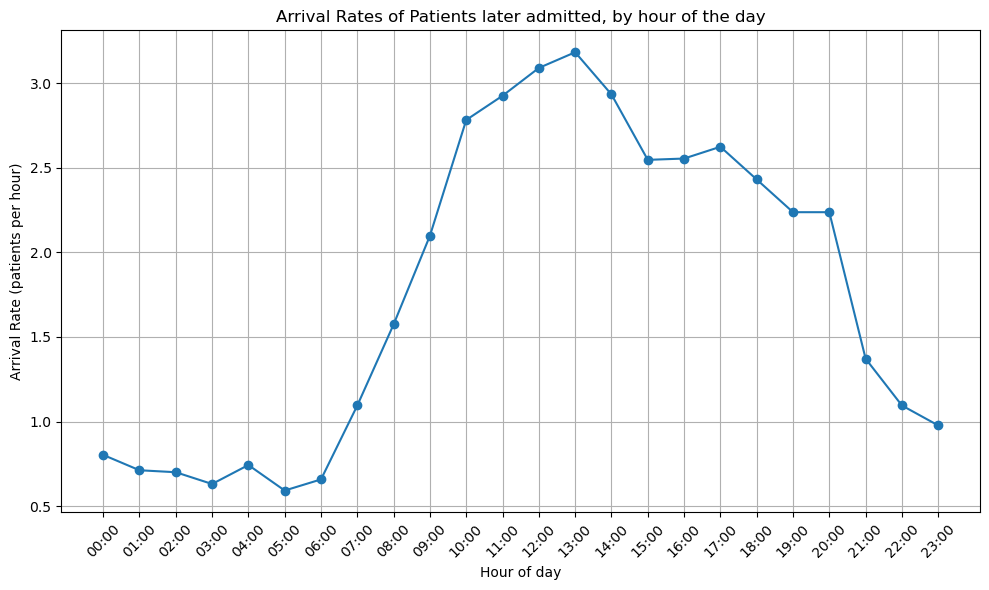

In [13]:
import matplotlib.pyplot as plt
import datetime

# Extract keys and values
hours = list(dict.keys())
arrival_rates = list(dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title('Arrival Rates of patients later admitted, by hour of the day')
plt.grid(True)
plt.tight_layout()
plt.show()

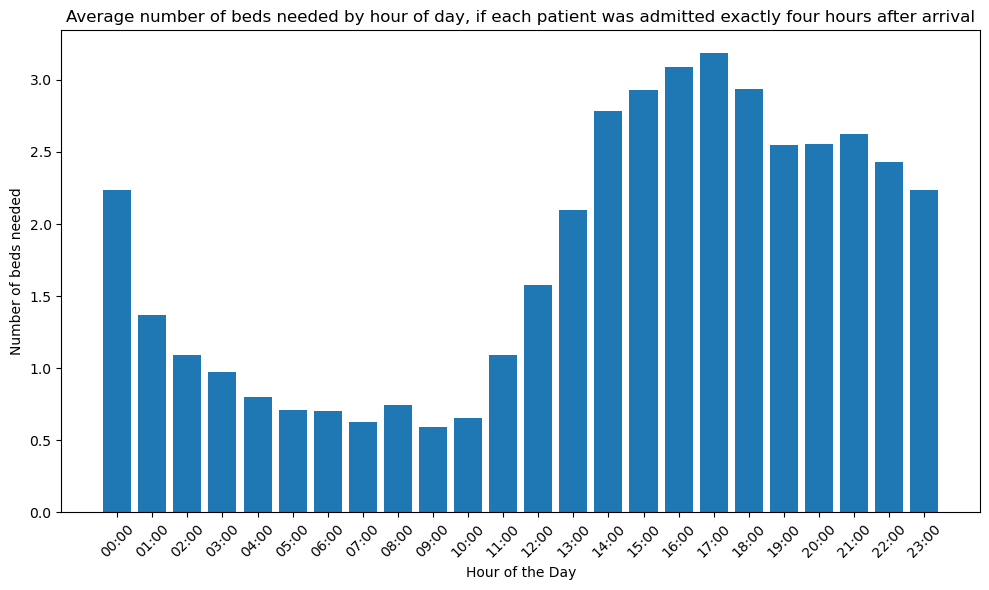

In [26]:
## Lag by four hours

from collections import OrderedDict

# Assuming 'dict' is already defined

# Lag the arrival times by 4 hours
lagged_dict = OrderedDict()
for time, rate in dict.items():
    lagged_time = (datetime.datetime.combine(datetime.date.today(), time) + datetime.timedelta(hours=4)).time()
    lagged_dict[lagged_time] = rate

# Sort the dictionary by the new lagged time
sorted_lagged_dict = OrderedDict(sorted(lagged_dict.items()))

# Extract keys and values from the sorted dictionary
hours = list(sorted_lagged_dict.keys())
arrival_rates = list(sorted_lagged_dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hour_labels, arrival_rates)
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of beds needed')
plt.title('Average number of beds needed by hour of day, if each patient was admitted exactly four hours after arrival')
# plt.grid(True)
plt.tight_layout()
plt.show()

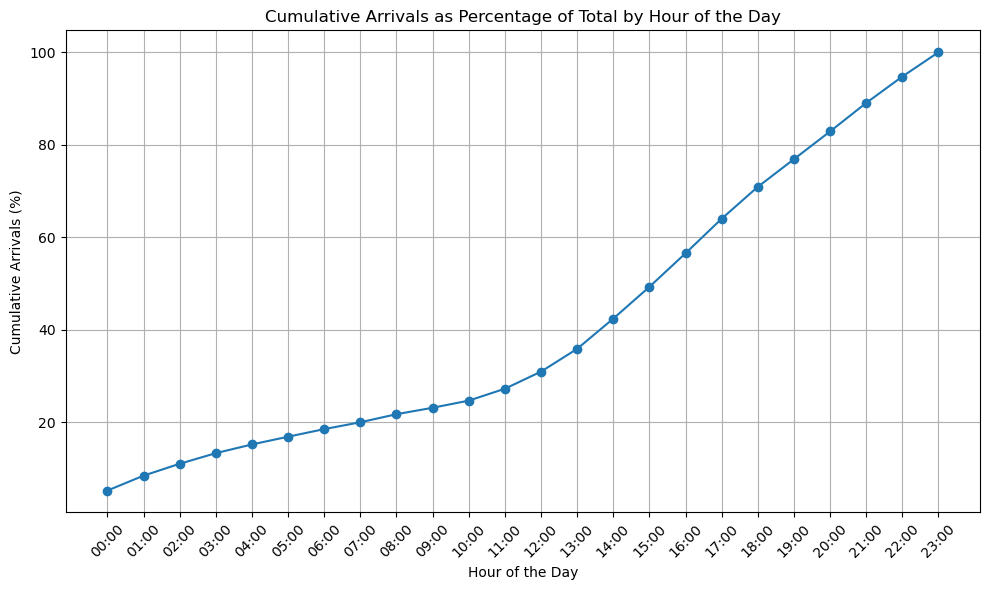

In [27]:
# Cumulative arrival rates

# Calculate cumulative arrivals
total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_percentage = (np.cumsum(arrival_rates) / total_arrivals) * 100


# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Arrivals (%)')
plt.title('Cumulative Arrivals as Percentage of Total by Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()

## For each hour after arrival, calculate the probability of being admitted in that hour if ED is performing according to targets

In [70]:
hours = np.arange(25)
print(hours)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [75]:
from predict.emergency_demand.admission_in_prediction_window_using_aspirational_curve import get_y_from_aspirational_curve
prob_admission_by_this_hour = []
for i in range(len(hours)):
    prob = get_y_from_aspirational_curve(hours[i], x1, y1, x2, y2)
    prob_admission_by_this_hour.append(prob)
prob_admission_by_this_hour = np.array(prob_admission_by_this_hour)
prob_admission_by_this_hour

array([0.01      , 0.02952592, 0.08717798, 0.25740098, 0.76      ,
       0.83868125, 0.89156776, 0.92711603, 0.95101021, 0.96707095,
       0.97786636, 0.98512262, 0.99      , 0.99327839, 0.99548199,
       0.99696317, 0.99795876, 0.99862796, 0.99907777, 0.99938011,
       0.99958333, 0.99971993, 0.99981175, 0.99987347, 0.99991495])

In [76]:
prob_admission_within_this_hour = np.diff(prob_admission_in_hour)
prob_admission_within_this_hour

array([1.95259172e-02, 5.76520616e-02, 1.70223000e-01, 5.02599021e-01,
       7.86812543e-02, 5.28865052e-02, 3.55482695e-02, 2.38941760e-02,
       1.60607438e-02, 1.07954127e-02, 7.25626013e-03, 4.87737826e-03,
       3.27838560e-03, 2.20360438e-03, 1.48117790e-03, 9.95590669e-04,
       6.69197658e-04, 4.49808861e-04, 3.02344172e-04, 2.03224094e-04,
       1.36599400e-04, 9.18168494e-05, 6.17157457e-05, 4.14829445e-05])

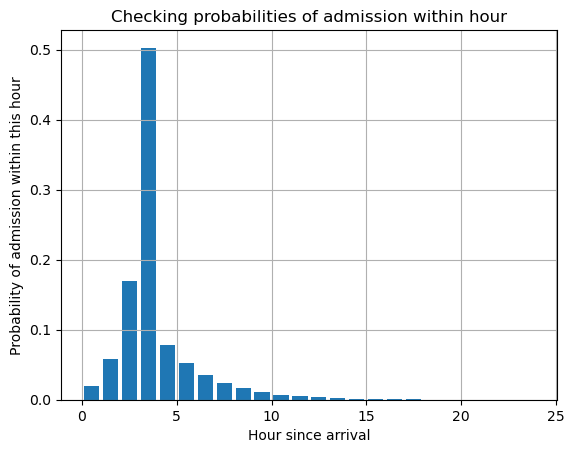

In [86]:
# plot these to check they are what we'd expect
plt.bar(np.arange(len(prob_admission_within_this_hour)) + 0.5, prob_admission_within_this_hour) # shifting bars to the left to portray the probability of admission within the hour
plt.xlabel('Hour since arrival')
plt.ylabel('Probability of admission within this hour')
plt.title('Checking probabilities of admission within hour')
plt.grid()
plt.show()

## For arrivals between midnight and 1 am

- a Poisson distribution for their arrival rate
- for their admissions between midnight and 1 am, weight with the first element in the probability to generate a Poisson
- for the admissions between 1 am and 2 am, weight with the first element in the probability to generate a Poisson
- etc

Each hour of the day has 24 poisson distributions, for arrivals in the previous 24 hours; can these be combined? 

In [88]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
poisson_means = calculate_rates(train_yta, time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 517 days


In [92]:
# Create an empty array to hold a Poisson distribution for each hour of the day, up to an arbitrary maximum number of arrivals in that hour
from scipy.stats import poisson
max_num_in_hour = 10

# Define the range of the random variable
x = np.arange(max_num_in_hour)

poisson_distributions = np.zeros((24, max_num_in_hour))

# Generate the Poisson distributions for each hour
for i, mean in enumerate(poisson_means.values()):
    poisson_distributions[i] = poisson.pmf(x, mean)

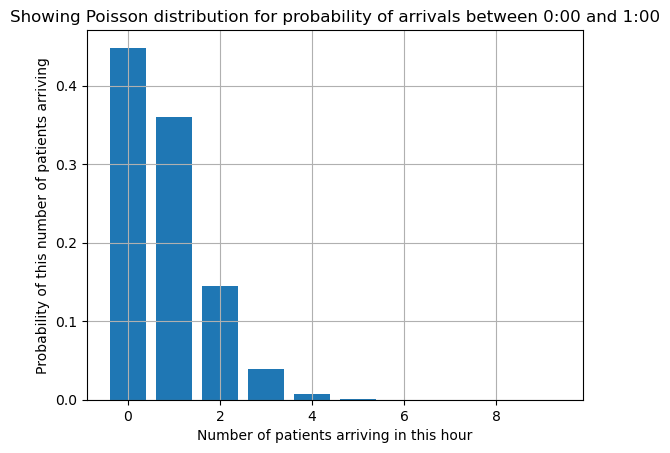

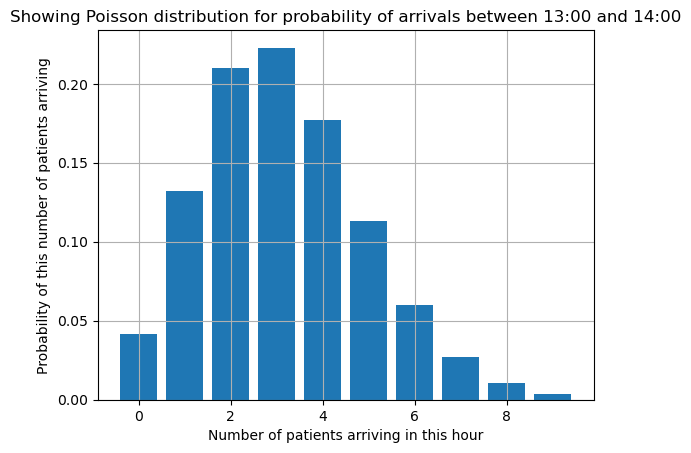

In [100]:
# plot the first distribution to check it's what what we'd expect
example_arrival_hour = 0 # 
plt.bar(np.arange(len(poisson_distributions[example_arrival_hour])) , poisson_distributions[example_arrival_hour])
plt.xlabel('Number of patients arriving in this hour')
plt.ylabel('Probability of this number of patients')
plt.title(f'Showing Poisson distribution for probability of arrivals between {str(example_arrival_hour)}:00 and {str(example_arrival_hour+1)}:00')
plt.grid()
plt.show()

example_arrival_hour = 13 # 
plt.bar(np.arange(len(poisson_distributions[example_arrival_hour])) , poisson_distributions[example_arrival_hour])
plt.xlabel('Number of patients arriving in this hour')
plt.ylabel('Probability of this number of patients')
plt.title(f'Showing Poisson distribution for probability of arrivals between {str(example_arrival_hour)}:00 and {str(example_arrival_hour+1)}:00')
plt.grid()
plt.show()

For each arrival hour, apply a weighting to reflect the patient's probability of being admitted within that hour

In [101]:
# Probability of being admitted within the zeroth hour 
prob_admission_within_this_hour[0]

0.01952591723737189

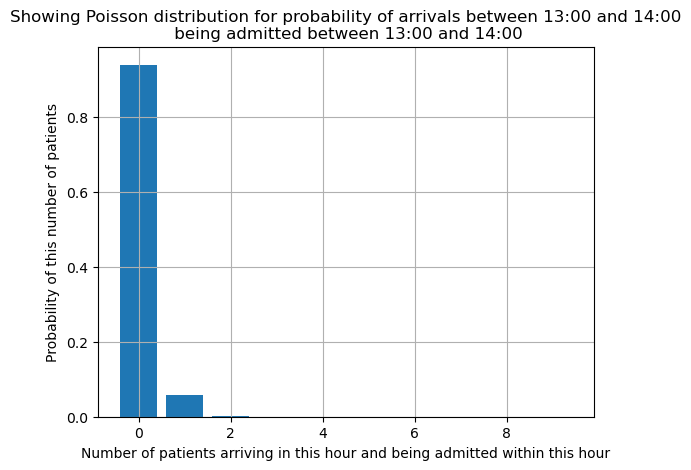

In [108]:
# Generate the Poisson distributions for each hour

poisson_distributions_hour_0 = np.zeros((24, max_num_in_hour))

for i, mean in enumerate(poisson_means.values()):
    poisson_distributions_hour_0[i] =  poisson.pmf(x, mean * prob_admission_within_this_hour[0])

example_arrival_hour = 13 # 
plt.bar(np.arange(len(poisson_distributions_hour_0[example_arrival_hour])) , poisson_distributions_hour_0[example_arrival_hour])
plt.xlabel('Number of patients arriving in this hour and being admitted within this hour')
plt.ylabel('Probability of this number of patients')
plt.title(f'Showing Poisson distribution for probability of arrivals between {str(example_arrival_hour)}:00 and {str(example_arrival_hour+1)}:00\n being admitted between {str(example_arrival_hour)}:00 and {str(example_arrival_hour+1)}:00')
plt.grid()
plt.show()

We know that the probability of being admitted is highest in the fourth hour (which is indexed in Python by 3 because Python indexing starts at zero) 

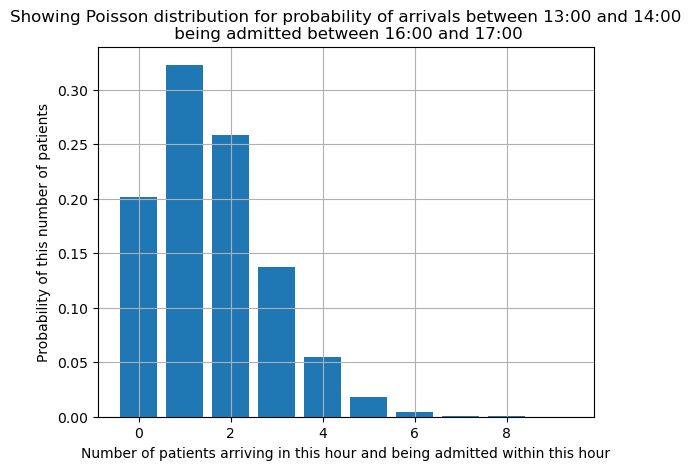

In [110]:
poisson_distributions_hour_3 = np.zeros((24, max_num_in_hour))

for i, mean in enumerate(poisson_means.values()):
    poisson_distributions_hour_3[i] =  poisson.pmf(x, mean * prob_admission_within_this_hour[3])

example_arrival_hour = 13 # 
plt.bar(np.arange(len(poisson_distributions_hour_3[example_arrival_hour])) , poisson_distributions_hour_3[example_arrival_hour])
plt.xlabel('Number of patients arriving in this hour and being admitted within this hour')
plt.ylabel('Probability of this number of patients')
plt.title(f'Showing Poisson distribution for probability of arrivals between {str(example_arrival_hour)}:00 and {str(example_arrival_hour+1)}:00\n being admitted between {str(example_arrival_hour + 3)}:00 and {str(example_arrival_hour+4)}:00')
plt.grid()
plt.show()

The intention now is to ripple this logic across the whole 24 hour period. 

To illustrate how this works, think about the admissions between 3 and 4 am. These will be made up of 
* arrivals between 3-4 am who are admitted within their zeroth hour
* arrivals between 2-3 am who are admitted within their first hour
* arrivals between 1-2 am who are admitted within their second hour
* arrivals between 0-1 am who are admitted within their third hour

Let's do this for these four hours

In [154]:
poisson_distributions_hour_0 # already holds a distribution for the number of patients who will be admitted with the zeroth hour, for each arrival hour in the day
poisson_distributions_hour_3 # already holds a distribution for the number of patients who will be admitted with the third hour, for each arrival hour in the day

# create the intervening arrays
poisson_distributions_hour_1 = np.zeros((24, max_num_in_hour))

for i, mean in enumerate(poisson_means.values()):
    poisson_distributions_hour_1[i] =  poisson.pmf(x, mean * prob_admission_within_this_hour[1])

poisson_distributions_hour_2 = np.zeros((24, max_num_in_hour))

for i, mean in enumerate(poisson_means.values()):
    poisson_distributions_hour_2[i] =  poisson.pmf(x, mean * prob_admission_within_this_hour[2])
# poisson_distributions_hour_2

The code below (where names have been simplied to A, B, C, D to make it clearer what is going on) collects togehter the probabilities from these different hours

In [156]:
# the total admissions at hour 3-4 are made up of 
A = poisson_distributions_hour_3[0]
B = poisson_distributions_hour_2[1]
C = poisson_distributions_hour_1[2]
D = poisson_distributions_hour_0[3]

beds_dict_for_hour_3 = {}

for a, proba in enumerate(A):
  for b, probb in enumerate(B):
    for c, probc in enumerate(C):
      for d, probd in enumerate(D):
         num_beds = a + b + c + d
         prob_num_beds = proba * probb* probc * probd
         if num_beds in beds_dict_for_hour_3:
             beds_dict_for_hour_3[num_beds] += prob_num_beds
         else:
             beds_dict_for_hour_3[num_beds] = prob_num_beds 
beds_dict_for_hour_3

{0: 0.5614207644584583,
 1: 0.3240995776197475,
 2: 0.09354885218274742,
 3: 0.018001438136146256,
 4: 0.0025979883831428524,
 5: 0.0002999557518859502,
 6: 2.8859974148095356e-05,
 7: 2.380059923387115e-06,
 8: 1.717465011789143e-07,
 9: 1.10162905759378e-08,
 10: 6.182801279456908e-10,
 11: 2.965446451071572e-11,
 12: 1.204029745917629e-12,
 13: 4.1561145761492345e-14,
 14: 1.233202081468323e-15,
 15: 3.1858916138371454e-17,
 16: 7.251777296949443e-19,
 17: 1.467659264810394e-20,
 18: 2.6482790078251465e-22,
 19: 4.198134030595203e-24,
 20: 5.743594909037414e-26,
 21: 6.731083049306897e-28,
 22: 6.77701906868567e-30,
 23: 5.912889905971044e-32,
 24: 4.516735026138653e-34,
 25: 3.04779835699886e-36,
 26: 1.8239336990059597e-38,
 27: 9.593407919093667e-41,
 28: 4.25976995178212e-43,
 29: 1.5574755230347776e-45,
 30: 4.692944239964128e-48,
 31: 1.1817783957921788e-50,
 32: 2.5296394326340967e-53,
 33: 4.668473533893479e-56,
 34: 7.4604381915775135e-59,
 35: 1.0031680267789978e-61,
 36: 

In [157]:
len(beds_dict_for_hour_3)

37

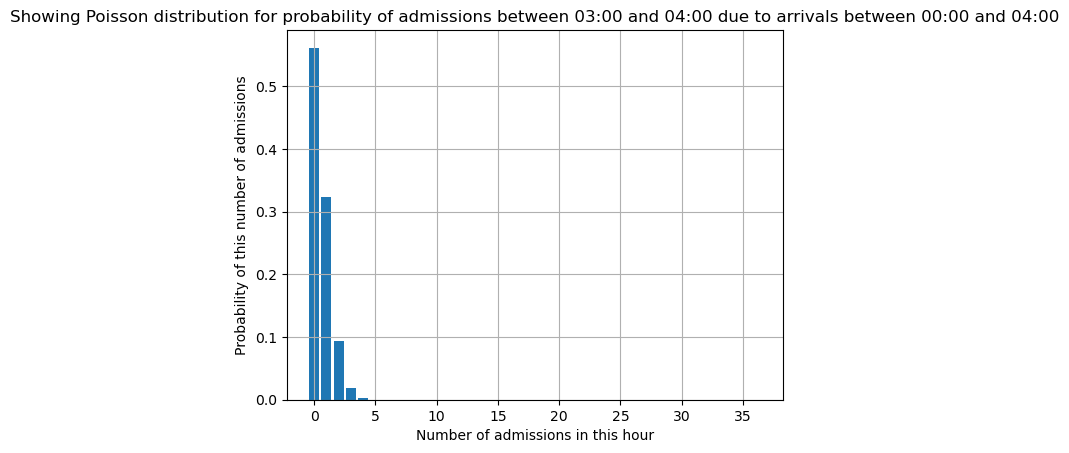

In [163]:

plt.bar(np.arange(len(beds_dict_for_hour_3)), beds_dict_for_hour_3.values())
plt.xlabel('Number of admissions in this hour')
plt.ylabel('Probability of this number of admissions')
plt.title(f'Showing Poisson distribution for probability of admissions between 03:00 and 04:00 due to arrivals between 00:00 and 04:00')
plt.grid()
plt.show()

Now let's make this more efficient, since we have 24 hour periods to deal with

In [195]:
# Create index arrays
indices_A = np.arange(len(A))
indices_B = np.arange(len(B))
indices_C = np.arange(len(C))
indices_D = np.arange(len(D))

# Compute all combinations of sums and products using indices
sums = np.add.outer(indices_A, np.add.outer(indices_B, np.add.outer(indices_C, indices_D)))
products = np.multiply.outer(A, np.multiply.outer(B, np.multiply.outer(C, D)))

# Flatten the arrays
sums_flat = sums.flatten()
products_flat = products.flatten()

# Aggregate the results into the dictionary
beds_dict_efficient = {}
for sum_val, prod_val in zip(sums_flat, products_flat):
    if sum_val in beds_dict_efficient:
        beds_dict_efficient[sum_val] += prod_val
    else:
        beds_dict_efficient[sum_val] = prod_val



In [198]:
np.multiply.outer(A, np.multiply.outer(B, np.multiply.outer(C, D))).flatten()

array([5.61420764e-01, 6.91236993e-03, 4.25535188e-05, ...,
       4.53551432e-59, 6.98031557e-62, 9.54928925e-65])

In [165]:
beds_dict_efficient

{0: 0.5614207644584583,
 1: 0.3240995776197475,
 2: 0.09354885218274742,
 3: 0.018001438136146256,
 4: 0.0025979883831428524,
 5: 0.0002999557518859502,
 6: 2.8859974148095356e-05,
 7: 2.3800599233871143e-06,
 8: 1.717465011789143e-07,
 9: 1.10162905759378e-08,
 10: 6.182801279456908e-10,
 11: 2.965446451071572e-11,
 12: 1.204029745917629e-12,
 13: 4.1561145761492345e-14,
 14: 1.233202081468323e-15,
 15: 3.1858916138371454e-17,
 16: 7.251777296949443e-19,
 17: 1.467659264810394e-20,
 18: 2.648279007825146e-22,
 19: 4.198134030595203e-24,
 20: 5.743594909037414e-26,
 21: 6.7310830493068975e-28,
 22: 6.777019068685672e-30,
 23: 5.912889905971044e-32,
 24: 4.516735026138653e-34,
 25: 3.04779835699886e-36,
 26: 1.82393369900596e-38,
 27: 9.593407919093669e-41,
 28: 4.25976995178212e-43,
 29: 1.5574755230347776e-45,
 30: 4.692944239964128e-48,
 31: 1.1817783957921788e-50,
 32: 2.5296394326340967e-53,
 33: 4.668473533893479e-56,
 34: 7.4604381915775135e-59,
 35: 1.0031680267789978e-61,
 36: 

In [166]:

def compute_beds_probabilities(*arrays):
    # Convert lists to NumPy arrays
    arrays = [np.array(arr) for arr in arrays]
    lengths = [len(arr) for arr in arrays]

    # Create grid of indices for all arrays
    indices = np.indices(lengths).reshape(len(arrays), -1)

    # Compute sums of indices
    sums = np.sum(indices, axis=0)

    # Compute products of probabilities
    probabilities = np.prod([arr[indices[i]] for i, arr in enumerate(arrays)], axis=0)

    # Aggregate results into the dictionary
    beds_dict = {}
    for sum_val, prob_val in zip(sums, probabilities):
        if sum_val in beds_dict:
            beds_dict[sum_val] += prob_val
        else:
            beds_dict[sum_val] = prob_val

    return beds_dict

compute_beds_probabilities(A, B, C, D)

{0: 0.5614207644584583,
 1: 0.3240995776197475,
 2: 0.09354885218274742,
 3: 0.018001438136146256,
 4: 0.0025979883831428524,
 5: 0.0002999557518859502,
 6: 2.8859974148095356e-05,
 7: 2.380059923387115e-06,
 8: 1.717465011789143e-07,
 9: 1.10162905759378e-08,
 10: 6.182801279456908e-10,
 11: 2.965446451071572e-11,
 12: 1.204029745917629e-12,
 13: 4.1561145761492345e-14,
 14: 1.233202081468323e-15,
 15: 3.1858916138371454e-17,
 16: 7.251777296949443e-19,
 17: 1.467659264810394e-20,
 18: 2.6482790078251465e-22,
 19: 4.198134030595203e-24,
 20: 5.743594909037414e-26,
 21: 6.731083049306897e-28,
 22: 6.77701906868567e-30,
 23: 5.912889905971044e-32,
 24: 4.516735026138653e-34,
 25: 3.04779835699886e-36,
 26: 1.8239336990059597e-38,
 27: 9.593407919093667e-41,
 28: 4.25976995178212e-43,
 29: 1.5574755230347776e-45,
 30: 4.692944239964128e-48,
 31: 1.1817783957921788e-50,
 32: 2.5296394326340967e-53,
 33: 4.668473533893479e-56,
 34: 7.4604381915775135e-59,
 35: 1.0031680267789978e-61,
 36: 

## Do this for all 24 hour periods

This code sets up a 3D array called poisson_distributions with dimensions (24, 24, max_num_in_hour), where:

* The first dimension represents the hour (0 to 23).
* The second dimension represents the different Poisson distributions for arrival rates within that hour, weighted by the probability of admission within that hour.
* The third dimension represents the values of the Poisson probability mass function.
  
Access the Poisson distribution for any specific hour and distribution using poisson_distributions[hour, i].

In [150]:
# Initialize a 3D array to hold all distributions across all hours
poisson_distributions = np.zeros((24, len(poisson_means), max_num_in_hour))

# Compute the Poisson distributions for each hour
for hour in range(24):
    for i, mean in enumerate(poisson_means.values()):
        poisson_distributions[hour, i] = poisson.pmf(x, mean * prob_admission_within_this_hour[hour])

# poisson_distributions now holds the distributions for all 24 hours


In [175]:
# the total admissions at hour 3-4 are made up of 
A = poisson_distributions_hour_3[0]
B = poisson_distributions_hour_2[1]
C = poisson_distributions_hour_1[2]
D = poisson_distributions_hour_0[3]

A == poisson_distributions[3][0]
B == poisson_distributions[2][1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Check we are indexing the 3D array correctly

In [179]:
hour = 3
A == poisson_distributions[hour][0]
B == poisson_distributions[hour-1][1]
C == poisson_distributions[hour-2][2]
D == poisson_distributions[hour-3][3]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

We can extract the relevant arrays for hour specified like this: 

In [201]:
# Extract the arrays based on the specified hour, and only including the previous three hours
arrays_for_hour = [
    poisson_distributions[hour - i][i]
    for i in range(4)
]

In [202]:
len(arrays_for_hour)

4

In [203]:
# Checking that we still get the same result as before

In [204]:
compute_beds_probabilities(*arrays_for_hour)

{0: 0.5614207644584583,
 1: 0.3240995776197475,
 2: 0.09354885218274742,
 3: 0.018001438136146256,
 4: 0.0025979883831428524,
 5: 0.0002999557518859502,
 6: 2.8859974148095356e-05,
 7: 2.380059923387115e-06,
 8: 1.717465011789143e-07,
 9: 1.10162905759378e-08,
 10: 6.182801279456908e-10,
 11: 2.965446451071572e-11,
 12: 1.204029745917629e-12,
 13: 4.1561145761492345e-14,
 14: 1.233202081468323e-15,
 15: 3.1858916138371454e-17,
 16: 7.251777296949443e-19,
 17: 1.467659264810394e-20,
 18: 2.6482790078251465e-22,
 19: 4.198134030595203e-24,
 20: 5.743594909037414e-26,
 21: 6.731083049306897e-28,
 22: 6.77701906868567e-30,
 23: 5.912889905971044e-32,
 24: 4.516735026138653e-34,
 25: 3.04779835699886e-36,
 26: 1.8239336990059597e-38,
 27: 9.593407919093667e-41,
 28: 4.25976995178212e-43,
 29: 1.5574755230347776e-45,
 30: 4.692944239964128e-48,
 31: 1.1817783957921788e-50,
 32: 2.5296394326340967e-53,
 33: 4.668473533893479e-56,
 34: 7.4604381915775135e-59,
 35: 1.0031680267789978e-61,
 36: 

### Expanding to include earlier periods

We can now compute the probability distribution for the number of beds between 3 and 4 am, due to arrivals going back earlier in time. As the probabilities do not change that much, we will only go back 8 hours to save compute

In [220]:
hour = 3
arrays_for_hour = [
    poisson_distributions[hour - i][i]
    for i in range(7)
]
beds_dict_for_hour = compute_beds_probabilities(*arrays_for_hour)

In [263]:
hour = 15
arrays_for_hour = [
    poisson_distributions[hour - i][i]
    for i in range(6)
]
beds_dict_for_hour = compute_beds_probabilities(*arrays_for_hour)

10


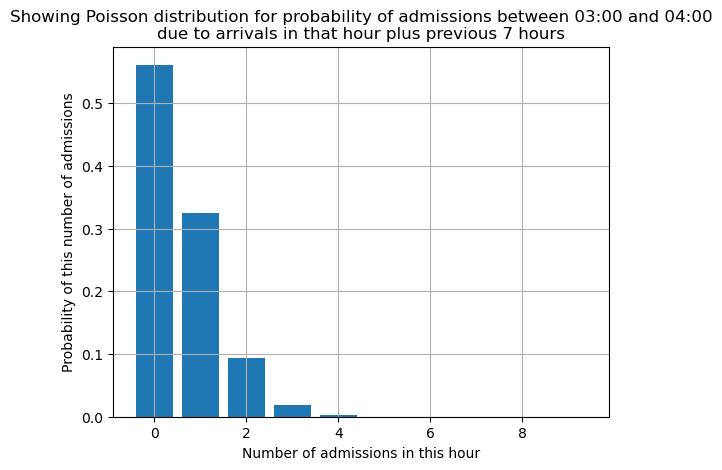

In [238]:
# Convert dictionary to numpy arrays
keys = np.array(list(beds_dict_for_hour.keys()))
values = np.array(list(beds_dict_for_hour.values()))

# Define the threshold of cumulative prob beyond which we don't need to see the x axis
threshold = 0.999999999

# Find the index where the cumulative sum exceeds the threshold
num_x_values = np.searchsorted(np.cumsum(values), threshold) + 1

print(num_x_values )

plt.bar(np.arange(num_x_values), values[:num_x_values])
plt.xlabel('Number of admissions in this hour')
plt.ylabel('Probability of this number of admissions')
plt.title(f'Showing Poisson distribution for probability of admissions between 03:00 and 04:00\ndue to arrivals in that hour plus previous 7 hours')
plt.grid()
plt.show()

In [219]:
prob_for_hour

{0: 0.5613490633374651,
 1: 0.32412988220691996,
 2: 0.09357829860340657,
 3: 0.018011088456032456,
 4: 0.002599956230871377,
 5: 0.00030024936778022846,
 6: 2.8894615539423002e-05,
 7: 2.3834439828948564e-06,
 8: 1.7202874910607812e-07,
 9: 1.1036836044866899e-08,
 10: 6.19609407934964e-10,
 11: 2.9729724929230265e-11,
 12: 1.2076680603928072e-12,
 13: 4.170984116210229e-14,
 14: 1.238362002897002e-15,
 15: 3.2012673422729986e-17,
 16: 7.291637463654866e-19,
 17: 1.4767587710814566e-20,
 18: 2.666742860152209e-22,
 19: 4.231537807135512e-24,
 20: 5.79669035883846e-26,
 21: 6.803915582561839e-28,
 22: 6.862583083811214e-30,
 23: 5.999231982510938e-32,
 24: 4.592224093441811e-34,
 25: 3.105574900183959e-36,
 26: 1.8629932494255035e-38,
 27: 9.827610496287342e-41,
 28: 4.383237177435306e-43,
 29: 1.6124649814745392e-45,
 30: 4.8947506626071486e-48,
 31: 1.2428440443682951e-50,
 32: 2.684117844511044e-53,
 33: 5.00072882681613e-56,
 34: 8.07672110337264e-59,
 35: 1.1022103163195807e-61,
 

### Plotting the whole day

In [243]:
beds_dict_for_day = {}

for hour in range(poisson_distributions.shape[0]):
    arrays_for_hour = [
        poisson_distributions[hour - i][i]
        for i in range(6)
    ]
    beds_dict_for_day[hour] = compute_beds_probabilities(*arrays_for_hour)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [245]:
# function to read a minimum number of beds needed based on an input probability(s) specified in sequence
def index_of_sum(sequence: list[float], max_sum: float) -> int:
    s = 0.0
    for i, p in enumerate(sequence):
        s += p
        if s >= 1 - max_sum:  ## only this line has changed
            return i
    return i

In [248]:
hours = beds_dict_for_day.keys()
index_of_sum(beds_dict_for_day[3].values(), 0.9)

0

In [254]:
cvisits_cut_point = [0.9]
min_num_beds_at_prob = np.zeros(len(beds_dict_for_day))
for hour in range(len(beds_dict_for_day)):
    min_num_beds_at_prob[hour] = index_of_sum(beds_dict_for_day[hour].values(), 0.9)

AttributeError: 'dict_values' object has no attribute 'cumsum'

In [258]:
np.array(list(beds_dict_for_day[15].values())).cumsum()


array([0.98670802, 0.99991127, 0.9999996 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [262]:
beds_dict_for_day[3]

{0: 0.5613829599949037,
 1: 0.32411555687474075,
 2: 0.09356437734517002,
 3: 0.018006525804977205,
 4: 0.0025990257785489957,
 5: 0.0003001105297367278,
 6: 2.8878234170863812e-05,
 7: 2.3818436195838477e-06,
 8: 1.7189526271802386e-07,
 9: 1.1027118695208616e-08,
 10: 6.189806646564343e-10,
 11: 2.969412445662005e-11,
 12: 1.2059468516287404e-12,
 13: 4.163948759454984e-14,
 14: 1.2359202864862257e-15,
 15: 3.193990263096926e-17,
 16: 7.272769120493577e-19,
 17: 1.472450640367757e-20,
 18: 2.657999601034535e-22,
 19: 4.2157168018101715e-24,
 20: 5.771536345212176e-26,
 21: 6.769399528236931e-28,
 22: 6.82201680916324e-30,
 23: 5.958277610552578e-32,
 24: 4.556399233658562e-34,
 25: 3.0781408999980286e-36,
 26: 1.8444358916656078e-38,
 27: 9.716269537285427e-41,
 28: 4.324495259673316e-43,
 29: 1.58627217728458e-45,
 30: 4.7984712818970176e-48,
 31: 1.213653972576344e-50,
 32: 2.6101159021065187e-53,
 33: 4.8411953774563785e-56,
 34: 7.78008245880659e-59,
 35: 1.0544066206925438e-61,
